# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

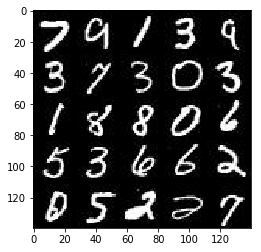

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

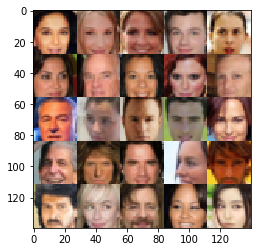

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return (inputs_real, inputs_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def leaky_relu(x, alpha): 
    return tf.maximum(alpha * x, x)

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse): 
        
        # Input layer : images size = 28*28*3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = leaky_relu(x1, alpha=alpha) # leaky ReLU
        # now 14*14*64
                
        # Conv layer with batch norm:
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2, alpha=alpha)
        # now 7*7*128

        # Conv layer with batch norm
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(bn3, alpha=alpha)
        # now 4*4*256
        
        # Conv layer with batch norm
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=reuse):
        # Reshape inputs from flat
        x1 = tf.layers.dense(z, 4*4*256)
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1, alpha=alpha)
        # now 4*4*256
        
        # Conv2d with transpose, batch norm, leaky ReLU
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2, alpha=alpha)
        # 7*7*128

        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3, alpha=alpha)
        # 14*14*64

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
    
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_output = generator(input_z, out_channel_dim, alpha=alpha)
    d_output_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_output_real)*(1 - smooth))
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_output_fake))
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_output_fake))
    )
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # all training variables
    t_vars = tf.trainable_variables()
    # discriminator variables
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    # generator variables
    g_vars = [v for v in t_vars if v.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    return samples

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
import pickle as pkl
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 10
    show_every = 100
    
    # TODO: Build Model
    all_samples, losses = [], []
    steps = 0
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[-1]
    
    inputs_real, inputs_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels, alpha=0.2)                
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Train
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr: learning_rate})
                
                # Print training progress
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({inputs_real:batch_images, inputs_z: batch_z, lr: learning_rate})
                    train_loss_g = g_loss.eval({inputs_z: batch_z, lr: learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_count+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                # Sample generator's output
                if steps % show_every == 0:
                    gen_samples = sess.run(generator(inputs_z, image_channels, is_train=False), feed_dict={inputs_z: batch_z})
                    all_samples.append(gen_samples)
                    show_generator_output(sess, 25, inputs_z, out_channel_dim=image_channels, image_mode=data_image_mode)
                
#         saver.save(sess, './checkpoints/generator.ckpt')
    
    with open('./samples.pkl', 'wb') as f:
        pkl.dump(all_samples, f)
    with open('./losses.pkl', 'wb') as g: 
        pkl.dump(losses, g)

    return losses, all_samples            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 4/3... Discriminator Loss: 0.9009... Generator Loss: 10.2965
Epoch 4/3... Discriminator Loss: 0.4650... Generator Loss: 2.8245
Epoch 4/3... Discriminator Loss: 1.0280... Generator Loss: 2.9547
Epoch 4/3... Discriminator Loss: 5.2837... Generator Loss: 18.6109
Epoch 4/3... Discriminator Loss: 0.7534... Generator Loss: 2.9867
Epoch 4/3... Discriminator Loss: 0.6878... Generator Loss: 1.6514
Epoch 4/3... Discriminator Loss: 0.6826... Generator Loss: 2.3340
Epoch 4/3... Discriminator Loss: 0.6465... Generator Loss: 2.5347
Epoch 4/3... Discriminator Loss: 0.7213... Generator Loss: 3.2658
Epoch 4/3... Discriminator Loss: 0.4268... Generator Loss: 3.6309


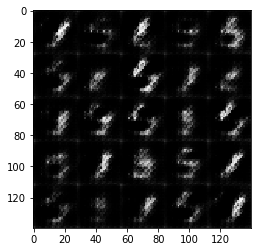

Epoch 4/3... Discriminator Loss: 1.0754... Generator Loss: 5.0983
Epoch 4/3... Discriminator Loss: 0.6282... Generator Loss: 1.8947
Epoch 4/3... Discriminator Loss: 0.4841... Generator Loss: 2.6108
Epoch 4/3... Discriminator Loss: 0.6936... Generator Loss: 3.7397
Epoch 4/3... Discriminator Loss: 1.4350... Generator Loss: 0.6521
Epoch 4/3... Discriminator Loss: 0.4848... Generator Loss: 2.7090
Epoch 4/3... Discriminator Loss: 0.4140... Generator Loss: 3.5731
Epoch 4/3... Discriminator Loss: 0.3907... Generator Loss: 3.5120
Epoch 4/3... Discriminator Loss: 1.5944... Generator Loss: 0.8557
Epoch 4/3... Discriminator Loss: 0.7052... Generator Loss: 12.4066


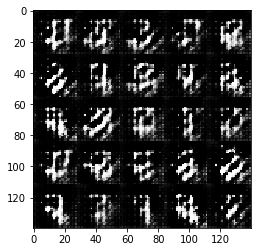

Epoch 4/3... Discriminator Loss: 0.3908... Generator Loss: 3.6672
Epoch 4/3... Discriminator Loss: 0.3750... Generator Loss: 3.6401
Epoch 4/3... Discriminator Loss: 0.3593... Generator Loss: 4.4208
Epoch 4/3... Discriminator Loss: 0.3480... Generator Loss: 4.6779
Epoch 4/3... Discriminator Loss: 0.3372... Generator Loss: 6.7978
Epoch 4/3... Discriminator Loss: 0.3877... Generator Loss: 3.0793
Epoch 4/3... Discriminator Loss: 0.6690... Generator Loss: 2.2540
Epoch 4/3... Discriminator Loss: 1.1229... Generator Loss: 0.9979
Epoch 4/3... Discriminator Loss: 0.5999... Generator Loss: 1.6612
Epoch 4/3... Discriminator Loss: 0.8418... Generator Loss: 1.2311


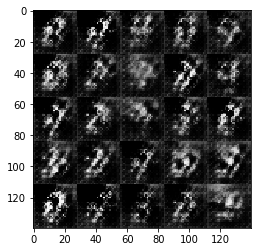

Epoch 4/3... Discriminator Loss: 0.4897... Generator Loss: 4.4849
Epoch 4/3... Discriminator Loss: 0.3927... Generator Loss: 6.8439
Epoch 4/3... Discriminator Loss: 0.7493... Generator Loss: 2.2361
Epoch 4/3... Discriminator Loss: 0.4731... Generator Loss: 2.4892
Epoch 4/3... Discriminator Loss: 0.6598... Generator Loss: 1.6256
Epoch 4/3... Discriminator Loss: 1.0186... Generator Loss: 0.9005
Epoch 4/3... Discriminator Loss: 0.9319... Generator Loss: 0.8938
Epoch 4/3... Discriminator Loss: 0.6946... Generator Loss: 1.4882
Epoch 4/3... Discriminator Loss: 0.4800... Generator Loss: 2.3751
Epoch 4/3... Discriminator Loss: 0.4552... Generator Loss: 2.5441


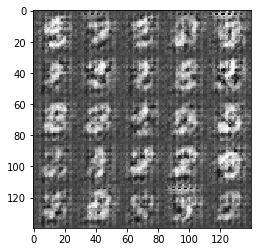

Epoch 4/3... Discriminator Loss: 1.3154... Generator Loss: 0.6053
Epoch 4/3... Discriminator Loss: 0.6144... Generator Loss: 2.3924
Epoch 4/3... Discriminator Loss: 0.6425... Generator Loss: 3.1195
Epoch 4/3... Discriminator Loss: 0.6277... Generator Loss: 2.1463
Epoch 4/3... Discriminator Loss: 0.5474... Generator Loss: 2.2107
Epoch 4/3... Discriminator Loss: 1.5563... Generator Loss: 2.6796
Epoch 4/3... Discriminator Loss: 1.1272... Generator Loss: 2.0705
Epoch 4/3... Discriminator Loss: 0.8903... Generator Loss: 2.5270
Epoch 4/3... Discriminator Loss: 0.6954... Generator Loss: 1.4549
Epoch 4/3... Discriminator Loss: 1.1995... Generator Loss: 5.3812


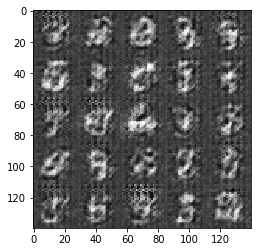

Epoch 4/3... Discriminator Loss: 0.4790... Generator Loss: 2.6874
Epoch 4/3... Discriminator Loss: 0.8984... Generator Loss: 1.0241
Epoch 4/3... Discriminator Loss: 0.4676... Generator Loss: 2.5495
Epoch 4/3... Discriminator Loss: 1.3730... Generator Loss: 1.4068
Epoch 4/3... Discriminator Loss: 0.6867... Generator Loss: 1.8927
Epoch 4/3... Discriminator Loss: 0.4923... Generator Loss: 2.3424
Epoch 4/3... Discriminator Loss: 0.5685... Generator Loss: 1.6925
Epoch 4/3... Discriminator Loss: 0.3904... Generator Loss: 4.0535
Epoch 4/3... Discriminator Loss: 0.4433... Generator Loss: 2.6275
Epoch 4/3... Discriminator Loss: 0.5144... Generator Loss: 1.9660


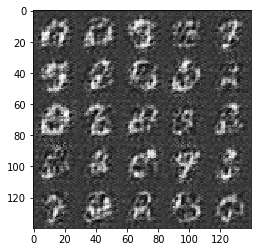

Epoch 4/3... Discriminator Loss: 0.3573... Generator Loss: 4.6702
Epoch 4/3... Discriminator Loss: 0.5545... Generator Loss: 2.0006
Epoch 4/3... Discriminator Loss: 0.4040... Generator Loss: 5.9251
Epoch 4/3... Discriminator Loss: 0.3546... Generator Loss: 5.4084
Epoch 4/3... Discriminator Loss: 2.2665... Generator Loss: 4.4484
Epoch 4/3... Discriminator Loss: 1.2578... Generator Loss: 0.7546
Epoch 4/3... Discriminator Loss: 0.9143... Generator Loss: 1.4314
Epoch 4/3... Discriminator Loss: 0.9344... Generator Loss: 2.4247
Epoch 4/3... Discriminator Loss: 0.9775... Generator Loss: 1.2556
Epoch 4/3... Discriminator Loss: 1.0435... Generator Loss: 2.8565


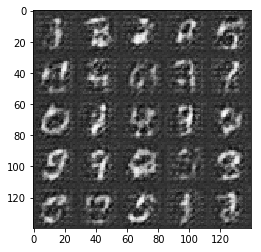

In [13]:
batch_size = 256
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
batch = mnist_dataset.get_batches(batch_size)
test_batch = batch.__next__()
shape = mnist_dataset.shape
image_mode = mnist_dataset.image_mode

with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

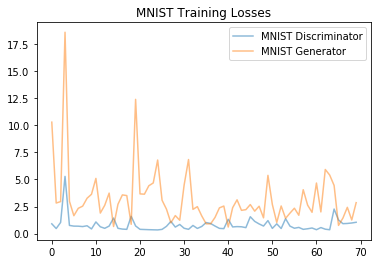

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='MNIST Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='MNIST Generator', alpha=0.5)
plt.title("MNIST Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 2/1... Discriminator Loss: 9.2890... Generator Loss: 0.0002
Epoch 2/1... Discriminator Loss: 0.4518... Generator Loss: 3.7910
Epoch 2/1... Discriminator Loss: 3.3716... Generator Loss: 19.5361
Epoch 2/1... Discriminator Loss: 0.6301... Generator Loss: 3.6703
Epoch 2/1... Discriminator Loss: 1.0948... Generator Loss: 1.1377
Epoch 2/1... Discriminator Loss: 0.7293... Generator Loss: 4.7849
Epoch 2/1... Discriminator Loss: 0.6470... Generator Loss: 1.7793
Epoch 2/1... Discriminator Loss: 0.5795... Generator Loss: 1.8347
Epoch 2/1... Discriminator Loss: 0.4956... Generator Loss: 2.8171
Epoch 2/1... Discriminator Loss: 0.4195... Generator Loss: 3.1566


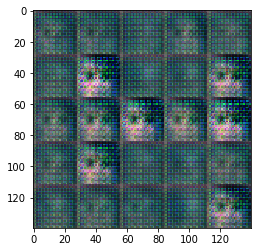

Epoch 2/1... Discriminator Loss: 0.4448... Generator Loss: 3.5345
Epoch 2/1... Discriminator Loss: 2.7614... Generator Loss: 0.4028
Epoch 2/1... Discriminator Loss: 1.4682... Generator Loss: 0.9099
Epoch 2/1... Discriminator Loss: 0.5267... Generator Loss: 2.4536
Epoch 2/1... Discriminator Loss: 0.6257... Generator Loss: 1.9693
Epoch 2/1... Discriminator Loss: 0.4743... Generator Loss: 3.5660
Epoch 2/1... Discriminator Loss: 0.4914... Generator Loss: 3.5233
Epoch 2/1... Discriminator Loss: 2.3136... Generator Loss: 0.6091
Epoch 2/1... Discriminator Loss: 0.9278... Generator Loss: 1.6244
Epoch 2/1... Discriminator Loss: 0.7522... Generator Loss: 1.3025


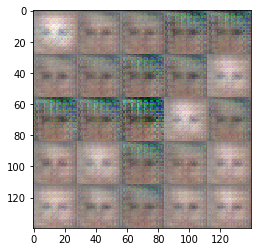

Epoch 2/1... Discriminator Loss: 0.8288... Generator Loss: 1.0955
Epoch 2/1... Discriminator Loss: 0.7989... Generator Loss: 1.4165
Epoch 2/1... Discriminator Loss: 1.0395... Generator Loss: 1.7233
Epoch 2/1... Discriminator Loss: 1.2515... Generator Loss: 1.0049
Epoch 2/1... Discriminator Loss: 1.4082... Generator Loss: 0.7250
Epoch 2/1... Discriminator Loss: 1.1683... Generator Loss: 0.7838
Epoch 2/1... Discriminator Loss: 1.0987... Generator Loss: 0.7851
Epoch 2/1... Discriminator Loss: 2.5032... Generator Loss: 4.0480
Epoch 2/1... Discriminator Loss: 1.2383... Generator Loss: 0.7148
Epoch 2/1... Discriminator Loss: 1.2547... Generator Loss: 1.3865


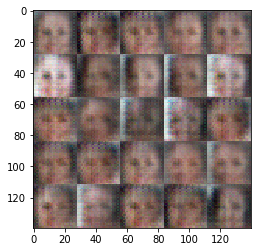

Epoch 2/1... Discriminator Loss: 0.6070... Generator Loss: 3.2911
Epoch 2/1... Discriminator Loss: 0.7182... Generator Loss: 1.8698
Epoch 2/1... Discriminator Loss: 0.9353... Generator Loss: 2.9699
Epoch 2/1... Discriminator Loss: 0.9837... Generator Loss: 1.0959
Epoch 2/1... Discriminator Loss: 1.7510... Generator Loss: 0.3910
Epoch 2/1... Discriminator Loss: 1.7354... Generator Loss: 2.2238
Epoch 2/1... Discriminator Loss: 1.2387... Generator Loss: 0.7490
Epoch 2/1... Discriminator Loss: 0.8509... Generator Loss: 1.0255
Epoch 2/1... Discriminator Loss: 1.4541... Generator Loss: 0.4627
Epoch 2/1... Discriminator Loss: 0.5781... Generator Loss: 2.2908


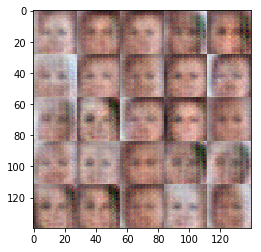

Epoch 2/1... Discriminator Loss: 0.7746... Generator Loss: 1.4353
Epoch 2/1... Discriminator Loss: 0.6883... Generator Loss: 2.7144
Epoch 2/1... Discriminator Loss: 0.4575... Generator Loss: 2.6554
Epoch 2/1... Discriminator Loss: 0.4514... Generator Loss: 2.3662
Epoch 2/1... Discriminator Loss: 0.6863... Generator Loss: 2.9914
Epoch 2/1... Discriminator Loss: 0.9045... Generator Loss: 1.1225
Epoch 2/1... Discriminator Loss: 0.3563... Generator Loss: 4.2586
Epoch 2/1... Discriminator Loss: 0.4393... Generator Loss: 2.5536
Epoch 2/1... Discriminator Loss: 0.9652... Generator Loss: 0.8724
Epoch 2/1... Discriminator Loss: 1.0560... Generator Loss: 0.7768


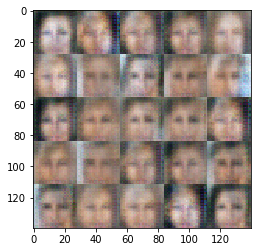

Epoch 2/1... Discriminator Loss: 1.0793... Generator Loss: 0.7584
Epoch 2/1... Discriminator Loss: 0.4380... Generator Loss: 3.9555
Epoch 2/1... Discriminator Loss: 0.5823... Generator Loss: 1.7609
Epoch 2/1... Discriminator Loss: 1.2550... Generator Loss: 2.3336
Epoch 2/1... Discriminator Loss: 0.5417... Generator Loss: 1.9923
Epoch 2/1... Discriminator Loss: 1.4520... Generator Loss: 0.7131
Epoch 2/1... Discriminator Loss: 0.6510... Generator Loss: 2.2903
Epoch 2/1... Discriminator Loss: 0.5093... Generator Loss: 4.0957
Epoch 2/1... Discriminator Loss: 0.4163... Generator Loss: 3.0072
Epoch 2/1... Discriminator Loss: 0.3875... Generator Loss: 3.3272


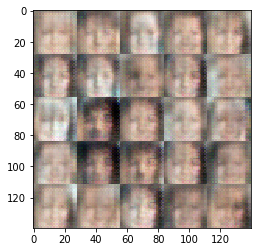

Epoch 2/1... Discriminator Loss: 1.0860... Generator Loss: 1.6932
Epoch 2/1... Discriminator Loss: 0.9732... Generator Loss: 2.8573
Epoch 2/1... Discriminator Loss: 0.4890... Generator Loss: 3.8809
Epoch 2/1... Discriminator Loss: 1.6304... Generator Loss: 2.3309
Epoch 2/1... Discriminator Loss: 0.8147... Generator Loss: 1.6792
Epoch 2/1... Discriminator Loss: 0.4149... Generator Loss: 2.8890
Epoch 2/1... Discriminator Loss: 0.7828... Generator Loss: 1.1080
Epoch 2/1... Discriminator Loss: 1.1626... Generator Loss: 2.3741
Epoch 2/1... Discriminator Loss: 0.6714... Generator Loss: 2.0518
Epoch 2/1... Discriminator Loss: 1.3110... Generator Loss: 0.6620


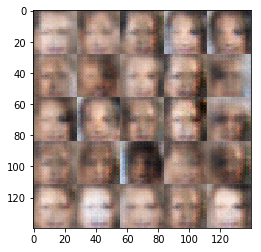

Epoch 2/1... Discriminator Loss: 0.6471... Generator Loss: 1.5336
Epoch 2/1... Discriminator Loss: 2.8276... Generator Loss: 0.1191
Epoch 2/1... Discriminator Loss: 0.8667... Generator Loss: 1.3216
Epoch 2/1... Discriminator Loss: 0.4977... Generator Loss: 2.5851
Epoch 2/1... Discriminator Loss: 0.4306... Generator Loss: 3.1248
Epoch 2/1... Discriminator Loss: 1.1839... Generator Loss: 1.9585
Epoch 2/1... Discriminator Loss: 0.6273... Generator Loss: 2.4042
Epoch 2/1... Discriminator Loss: 0.4925... Generator Loss: 3.5260
Epoch 2/1... Discriminator Loss: 1.3486... Generator Loss: 0.6347


In [14]:
batch_size = 256
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

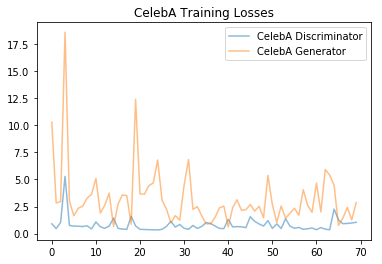

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='CelebA Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='CelebA Generator', alpha=0.5)
plt.title("CelebA Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.